## 딥러닝 Assignment2 _ 60201561 김아영



Colab에서 Perceptron 구현과 pytorch MLP 사용 및 classification 성능 확인

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

* Linearly separable / 2d binary class (𝑥1, 𝑥2, 𝑦)를 가지고 있는 서로 다른 data point class 별로 100개씩 생성하고 랜덤하게 70%는 train / 30%는 test 셋으로 분리 (10)

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# 랜덤 시드 설정
np.random.seed(42)

# 클래스 0과 클래스 1의 데이터 생성
class_0_mean = (-5, 5) # 클래스 0의 데이터 평균값
class_1_mean = (5, -5) # 클래스 1의 데이터 평균값

class_0 = np.random.normal(loc=class_0_mean, scale=3, size=(100, 2)) # 클래스 0의 데이터 생성
class_1 = np.random.normal(loc=class_1_mean, scale=3, size=(100, 2)) # 클래스 1의 데이터 생성

# 클래스 레이블 생성 (0: 클래스 0 / 1: 클래스 1)
class_0_labels=np.zeros(100)
class_1_labels=np.ones(100)

# 데이터와 레이블을 합치기
class_0=np.column_stack((class_0, class_0_labels))
class_1=np.column_stack((class_1, class_1_labels))

# 전체 데이터 합치기
data=np.vstack((class_0, class_1))

# data 살펴보기
print(data)
print(data.shape)

[[ -3.50985754   4.5852071    0.        ]
 [ -3.05693439   9.56908957   0.        ]
 [ -5.70246012   4.29758913   0.        ]
 [ -0.26236155   7.30230419   0.        ]
 [ -6.40842316   6.62768013   0.        ]
 [ -6.39025308   3.60281074   0.        ]
 [ -4.27411319  -0.73984073   0.        ]
 [-10.1747535    3.31313741   0.        ]
 [ -8.03849336   5.942742     0.        ]
 [ -7.72407223   0.7630889    0.        ]
 [ -0.60305369   4.3226711    0.        ]
 [ -4.79741539   0.72575544   0.        ]
 [ -6.63314817   5.33276777   0.        ]
 [ -8.45298073   6.12709406   0.        ]
 [ -6.80191607   4.12491875   0.        ]
 [ -6.80511984  10.55683455   0.        ]
 [ -5.04049167   1.82686721   0.        ]
 [ -2.53236526   1.33746905   0.        ]
 [ -4.37340921  -0.87901037   0.        ]
 [ -8.98455815   5.59058371   0.        ]
 [ -2.78460026   5.51410484   0.        ]
 [ -5.34694485   4.09668891   0.        ]
 [ -9.43556597   2.84046737   0.        ]
 [ -6.38191631   8.17136668   0.  

In [4]:
# Train set 과 Test set으로 분할 (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.30, random_state=42)

* 2d visualization을 통하여 실제로 linearly separable한 data인지 확인 할 수 있는 scatter plot 생성 (10)
 - train / test는 dot의 모양으로 class는 색으로 구분

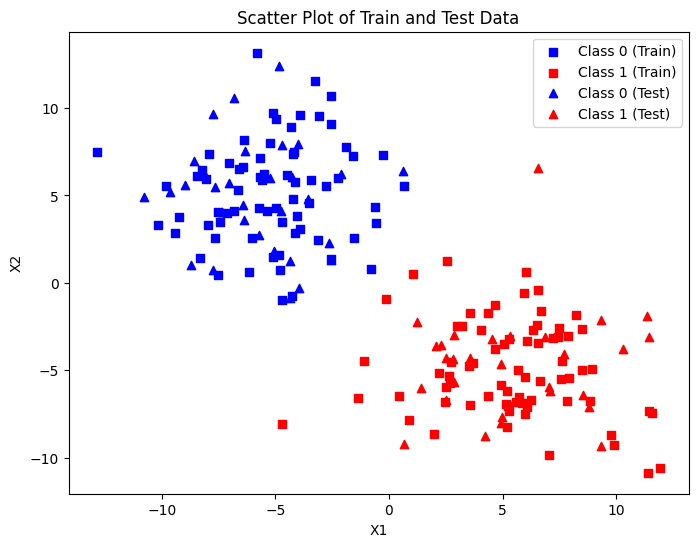

In [5]:
# 데이터 시각화 (scatter plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# train data는 네모 / test data는 세모로 구분 / class는 파랑색과 빨강색으로 구분
plt.scatter(X_train[y_train == 0 ][:, 0], X_train[y_train == 0][:,1], c='blue', marker='s', label='Class 0 (Train)')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:,1], c='red', marker='s', label='Class 1 (Train)')
plt.scatter(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], c='blue', marker='^', label='Class 0 (Test)')
plt.scatter(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], c='red', marker='^', label='Class 1 (Test)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of Train and Test Data')
plt.legend()
plt.show()

* training data를 사용하여 perceptron을 training 하고 train accuracy / test accuracy 작성
 - perceptron을 구현 할 때에는 tensor / numpy / pandas 등의 data를 다루기 위한 package 말고 어떠한 package도 사용 불가능

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
#torch.tensor() : 다양한 데이터 유형을 허용하며 주어진 데이터의 타입에 따라 자동으로 데이터 타입을 결정
X_train, X_test=torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test=torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

X_train=X_train.to(device)
X_test=X_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([140, 2]) torch.Size([140]) torch.Size([60, 2]) torch.Size([60])


In [8]:
#Perceptron 구현

class Perceptron:
  def __init__(self, input_size, device):
    self.weights = torch.zeros(input_size, device=device, dtype=torch.float32)
    self.bias = torch.tensor(0, device=device, dtype=torch.float32)

  def activation_function(self, x):
    return torch.where(x>0, torch.tensor(1), torch.tensor(0))

  def predict(self, x):
    # 가중치의 합과 bias를 이용하여 예측 수행
    weights_cpu=self.weights.cpu()
    bias_cpu=self.bias.cpu()
    x_cpu=x.cpu().T # 전치하여 모양 변경
    return self.activation_function(torch.matmul(weights_cpu, x_cpu) + bias_cpu)

  def train(self, X_train, y_train, learning_rate=0.01, epochs=1000):
    for _ in range(epochs):
      for inputs, label in zip(X_train, y_train):
        prediction = self.predict(inputs)
        # 예측이 틀렸을 때만 가중치 및 바이어스 업데이트
        if prediction != label:
          self.weights += learning_rate * (label - prediction) * inputs
          self.bias += learning_rate * (label - prediction)

  def accuracy(self, X, y):
    correct = 0
    for inputs, label in zip(X, y):
      if self.predict(inputs) == label:
        correct+=1
    return correct / len(y)

# Perceptron 객체 생성
perceptron = Perceptron(input_size=X_train.shape[1], device=device)

# Training
perceptron.train(X_train, y_train)

# train 및 test accuracy 계산
train_accuracy = perceptron.accuracy(X_train, y_train)
test_accuracy = perceptron.accuracy(X_test, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

<ipython-input-8-8551e715d7bf>:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  x_cpu=x.cpu().T # 전치하여 모양 변경


Train Accuracy: 1.0
Test Accuracy: 0.9833333333333333


*  perceptron의 decision boundary와 data를 2d상에서 확인 할 수 있도록 plot 생성 (10)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


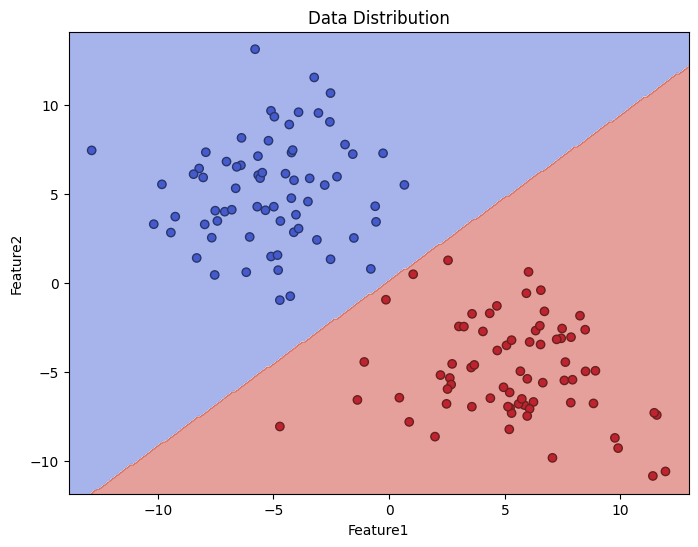

In [9]:
# 데이터 분포 시각화
X_train_cpu = X_train.cpu()
y_train_cpu = y_train.cpu()

plt.figure(figsize=(8, 6))
plt.scatter(X_train_cpu[:, 0], X_train_cpu[:, 1], c=y_train_cpu, cmap='coolwarm', edgecolors='k')
plt.title('Data Distribution')
plt.xlabel('Feature1')
plt.ylabel('Feature2')

# 결정 경계 시각화
weights_cpu = perceptron.weights.cpu().detach().numpy()
bias_cpu = perceptron.bias.cpu().item()

x_min, x_max = X_train_cpu[:,0].min()-1, X_train_cpu[:,0].max()+1
y_min, y_max = X_train_cpu[:,1].min()-1, X_train_cpu[:,1].max()+1

xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.1), torch.arange(y_min, y_max, 0.1))
Z = perceptron.predict(torch.vstack((xx.flatten(), yy.flatten())).T).reshape(xx.shape)

plt.contourf(xx, yy, Z.detach().numpy(), alpha=0.5, cmap='coolwarm')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

* XOR 형태의 Nonlinearly separable 2d binary class를 가지고 있는 서로 다른 data point class 별로 100개씩 생성하고 랜덤하게 70%는 train / 30%
는 test 셋으로 분리 (10)


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 랜덤 시드 설정
np.random.seed(42)

# 클래스 1 데이터 생성
class_1_points_1 = np.random.rand(50, 2)
class_1_points_2 = np.random.rand(50, 2) + 1
class_1_labels = np.zeros(100)  # 클래스 1에 대한 레이블은 0

# 클래스 2 데이터 생성
class_2_points_1 = np.random.rand(50, 2)
class_2_points_1[:, 1] += 1
class_2_points_2 = np.random.rand(50, 2)
class_2_points_2[:, 0] += 1
class_2_labels = np.ones(100)  # 클래스 2에 대한 레이블은 1

# 데이터 포인트와 레이블 합치기
class_1_data = np.column_stack((np.vstack((class_1_points_1, class_1_points_2)), class_1_labels))
class_2_data = np.column_stack((np.vstack((class_2_points_1, class_2_points_2)), class_2_labels))

# 전체 데이터 결합하기
xor_data = np.vstack((class_1_data, class_2_data))

# 데이터 살펴보기
print(xor_data)
print(xor_data.shape)

[[0.37454012 0.95071431 0.        ]
 [0.73199394 0.59865848 0.        ]
 [0.15601864 0.15599452 0.        ]
 [0.05808361 0.86617615 0.        ]
 [0.60111501 0.70807258 0.        ]
 [0.02058449 0.96990985 0.        ]
 [0.83244264 0.21233911 0.        ]
 [0.18182497 0.18340451 0.        ]
 [0.30424224 0.52475643 0.        ]
 [0.43194502 0.29122914 0.        ]
 [0.61185289 0.13949386 0.        ]
 [0.29214465 0.36636184 0.        ]
 [0.45606998 0.78517596 0.        ]
 [0.19967378 0.51423444 0.        ]
 [0.59241457 0.04645041 0.        ]
 [0.60754485 0.17052412 0.        ]
 [0.06505159 0.94888554 0.        ]
 [0.96563203 0.80839735 0.        ]
 [0.30461377 0.09767211 0.        ]
 [0.68423303 0.44015249 0.        ]
 [0.12203823 0.49517691 0.        ]
 [0.03438852 0.9093204  0.        ]
 [0.25877998 0.66252228 0.        ]
 [0.31171108 0.52006802 0.        ]
 [0.54671028 0.18485446 0.        ]
 [0.96958463 0.77513282 0.        ]
 [0.93949894 0.89482735 0.        ]
 [0.59789998 0.92187424 0.  

In [12]:
# Train set 과 Test set으로 분할 (70% train, 30% test)

X_train_xor, X_test_xor, y_train_xor, y_test_xor = train_test_split(xor_data[:, :-1], xor_data[:, -1], test_size=0.30, random_state=42)

# 분할된 데이터 크기 확인
print("Train set 크기:", X_train_xor.shape, y_train_xor.shape)
print("Test set 크기:", X_test_xor.shape, y_test_xor.shape)

Train set 크기: (140, 2) (140,)
Test set 크기: (60, 2) (60,)


* 2d visualization을 통하여 실제로 linearly separable한 data인지 확인 할 수 있는 plot 생성 (10)
 - train / test는 dot의 모양으로 class는 색으로 구분

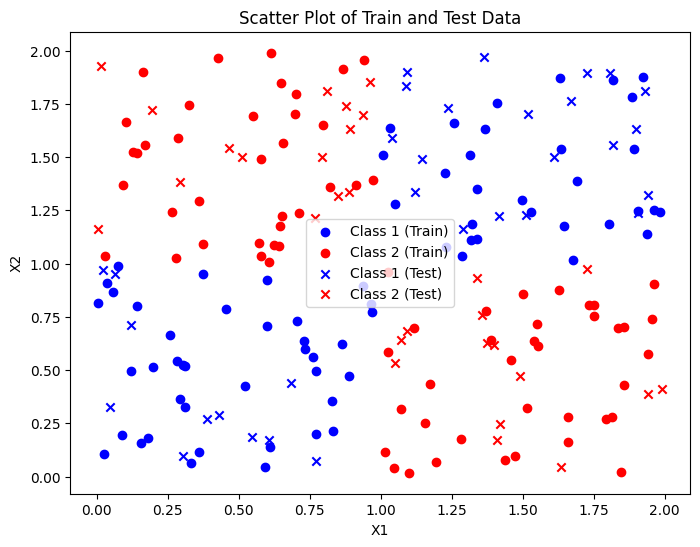

In [13]:
# 데이터 시각화 (scatter plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# train data는 O / test data는 X로 구분 / class는 파랑색과 빨강색으로 구분
plt.scatter(X_train_xor[y_train_xor == 0 ][:, 0], X_train_xor[y_train_xor == 0][:,1], c='blue', marker='o', label='Class 1 (Train)')
plt.scatter(X_train_xor[y_train_xor == 1][:, 0], X_train_xor[y_train_xor == 1][:,1], c='red', marker='o', label='Class 2 (Train)')
plt.scatter(X_test_xor[y_test_xor == 0][:,0], X_test_xor[y_test_xor == 0][:,1], c='blue', marker='x', label='Class 1 (Test)')
plt.scatter(X_test_xor[y_test_xor == 1][:,0], X_test_xor[y_test_xor == 1][:,1], c='red', marker='x', label='Class 2 (Test)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of Train and Test Data')
plt.legend()
plt.show()

* training data를 사용하여 위에서 구현한 perceptron으로 training 하고 train / test accuracy 작성 (10)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
#torch.tensor() : 다양한 데이터 유형을 허용하며 주어진 데이터의 타입에 따라 자동으로 데이터 타입을 결정
X_train_xor, X_test_xor=torch.tensor(X_train_xor, dtype=torch.float32), torch.tensor(X_test_xor, dtype=torch.float32)
y_train_xor, y_test_xor=torch.tensor(y_train_xor, dtype=torch.float32), torch.tensor(y_test_xor, dtype=torch.float32)

X_train_xor=X_train_xor.to(device)
X_test_xor=X_test_xor.to(device)
y_train_xor=y_train_xor.to(device)
y_test_xor=y_test_xor.to(device)

print(X_train_xor.shape, y_train_xor.shape, X_test_xor.shape, y_test_xor.shape)

torch.Size([140, 2]) torch.Size([140]) torch.Size([60, 2]) torch.Size([60])


In [16]:
# Perceptron 객체 생성
perceptron_xor = Perceptron(input_size=X_train_xor.shape[1], device=device)

# Training
perceptron_xor.train(X_train_xor, y_train_xor)

# train 및 test accuracy 계산
train_accuracy_xor = perceptron_xor.accuracy(X_train_xor, y_train_xor)
test_accuracy_xor = perceptron_xor.accuracy(X_test_xor, y_test_xor)

print("Train Accuracy:", train_accuracy_xor)
print("Test Accuracy:", test_accuracy_xor)

Train Accuracy: 0.5071428571428571
Test Accuracy: 0.65


* pytorch를 사용하여 Logistic regression / MLP를 구현하여 training data를 사용하여 training하고 train / test accuracy 작성 (15)
 - MLP는 하나의 hidden layer로 구성하고 hidden neuron은 2개로 작성


In [17]:
# Logistic regression 구현

from sklearn import metrics

class LogisticRegression(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    outputs=torch.sigmoid(self.linear(x))
    return outputs

# hyper parameters
epochs = 1000
input_dim = X_train_xor.shape[1]
output_dim = 2
lr=0.01

logistic_regression=LogisticRegression(input_dim, output_dim)
logistic_regression=logistic_regression.to(device)
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(logistic_regression.parameters(), lr=lr)

train_loss_arr=[]
test_loss_arr=[]

for i in range(epochs+1):
  ### train ###
  logistic_regression.train()
  optimizer.zero_grad()
  train_output=logistic_regression(X_train_xor)
  train_loss=criterion(train_output, y_train_xor.long())
  train_loss.backward()
  optimizer.step()

  if (i%100 == 0):
    ### test ###
    # 100 epoch 마다 loss 저장
    logistic_regression.eval()
    _, train_pred = torch.max(train_output.data, axis=1)
    with torch.no_grad():
      test_output=logistic_regression(X_test_xor)
      _, test_pred=torch.max(test_output.data, axis=1)
      test_loss=criterion(test_output, y_test_xor.long())

      train_loss_arr.append(train_loss.data)
      test_loss_arr.append(test_loss.data)

    if(i%100 == 0): # 100 epoch 마다 출력
      print("=====")
      print("epoch ", i)
      print("loss", train_loss.data, test_loss.data)
      print("train_accuracy {:.03f}".format(float((train_pred==y_train_xor).sum())/y_train_xor.size(0)))
      print("test_accuracy {:.03f}".format(float((test_pred==y_test_xor).sum())/y_test_xor.size(0)))

=====
epoch  0
loss tensor(0.6947, device='cuda:0') tensor(0.6959, device='cuda:0')
train_accuracy 0.314
test_accuracy 0.383
=====
epoch  100
loss tensor(0.6740, device='cuda:0') tensor(0.6814, device='cuda:0')
train_accuracy 0.621
test_accuracy 0.567
=====
epoch  200
loss tensor(0.6338, device='cuda:0') tensor(0.6445, device='cuda:0')
train_accuracy 0.521
test_accuracy 0.433
=====
epoch  300
loss tensor(0.6120, device='cuda:0') tensor(0.6253, device='cuda:0')
train_accuracy 0.550
test_accuracy 0.417
=====
epoch  400
loss tensor(0.5995, device='cuda:0') tensor(0.6147, device='cuda:0')
train_accuracy 0.550
test_accuracy 0.467
=====
epoch  500
loss tensor(0.5915, device='cuda:0') tensor(0.6081, device='cuda:0')
train_accuracy 0.557
test_accuracy 0.467
=====
epoch  600
loss tensor(0.5859, device='cuda:0') tensor(0.6036, device='cuda:0')
train_accuracy 0.557
test_accuracy 0.467
=====
epoch  700
loss tensor(0.5817, device='cuda:0') tensor(0.6004, device='cuda:0')
train_accuracy 0.550
test_a

> XOR 데이터셋은 선형적으로 분리되지 않는 문제이다. 로지스틱 회귀 모델은 입력 공간을 선형적으로 분리하는 경계를 찾는 모델이므로 XOR 데이터셋과 같이 비선형적으로 분포된 데이터를 분류하기에는 적합하지 않다.


> 따라서 XOR 데이터셋에 대해 로지스틱 회귀 모델을 사용하는 것은 적절하지 않다. 비선형 분류 문제를 해결할 수 있는 다층 퍼셉트론(MLP)과 같은 신경망 구조를 사용할 수 있다. 이러한 모델은 비선형 활성화 함수를 사용하여 데이터를 비선형적으로 분리할 수 있다.

- *이어서 아래 코드 셀에 MLP를 구현한 뒤 training data를 사용하여 training하고 train / test accuracy 를 출력 -> 차이점 확인*

In [18]:
# MLP 구현

import torch
import torch.nn.functional as F

class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(2, 512),
        nn.ReLU(),
        nn.Linear(512, 512), #트레이드오프(Trade-off)를 고려할 시 은닉차원 512가 가장 적합하다고 판단
        nn.ReLU(),
        nn.Linear(512, 2),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [19]:
lr = 0.001
epochs = 2000
model = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 최적화 알고리즘 Adam 사용

loss_save_arr=[]
for i in range(epochs+1):
  ##### train #####
  model.train()
  optimizer.zero_grad()
  output=model(X_train_xor)
  loss=criterion(output, y_train_xor.long())
  loss.backward()
  optimizer.step()

  loss_save_arr.append(loss.data)
  if(i%100 == 0):
    print("=====")
    print('epoch ', i)
    print('loss ', loss.data)
    _, pred=torch.max(output.data, axis=1)
    print("train_accuracy {:0.3f}".format(float((pred==y_train_xor).sum())/y_train_xor.size(0)))

  ##### test #####
    model.eval()
    with torch.no_grad():
      output=model(X_test_xor)
      _, pred = torch.max(output.data, axis=1)
      print("test_accuracy {:0.3f}".format(float((pred==y_test_xor).sum())/y_test_xor.size(0)))

=====
epoch  0
loss  tensor(0.6920, device='cuda:0')
train_accuracy 0.479
test_accuracy 0.483
=====
epoch  100
loss  tensor(0.3349, device='cuda:0')
train_accuracy 0.993
test_accuracy 0.983
=====
epoch  200
loss  tensor(0.3211, device='cuda:0')
train_accuracy 1.000
test_accuracy 0.967
=====
epoch  300
loss  tensor(0.3168, device='cuda:0')
train_accuracy 1.000
test_accuracy 0.967
=====
epoch  400
loss  tensor(0.3151, device='cuda:0')
train_accuracy 1.000
test_accuracy 0.967
=====
epoch  500
loss  tensor(0.3143, device='cuda:0')
train_accuracy 1.000
test_accuracy 0.983
=====
epoch  600
loss  tensor(0.3139, device='cuda:0')
train_accuracy 1.000
test_accuracy 0.983
=====
epoch  700
loss  tensor(0.3137, device='cuda:0')
train_accuracy 1.000
test_accuracy 0.983
=====
epoch  800
loss  tensor(0.3136, device='cuda:0')
train_accuracy 1.000
test_accuracy 0.983
=====
epoch  900
loss  tensor(0.3135, device='cuda:0')
train_accuracy 1.000
test_accuracy 0.983
=====
epoch  1000
loss  tensor(0.3134, dev

* perceptron / logistic regression model의 decision boundary와 data를 2d상에서 확인 할 수 있도록 각각 plot 생성 (10)

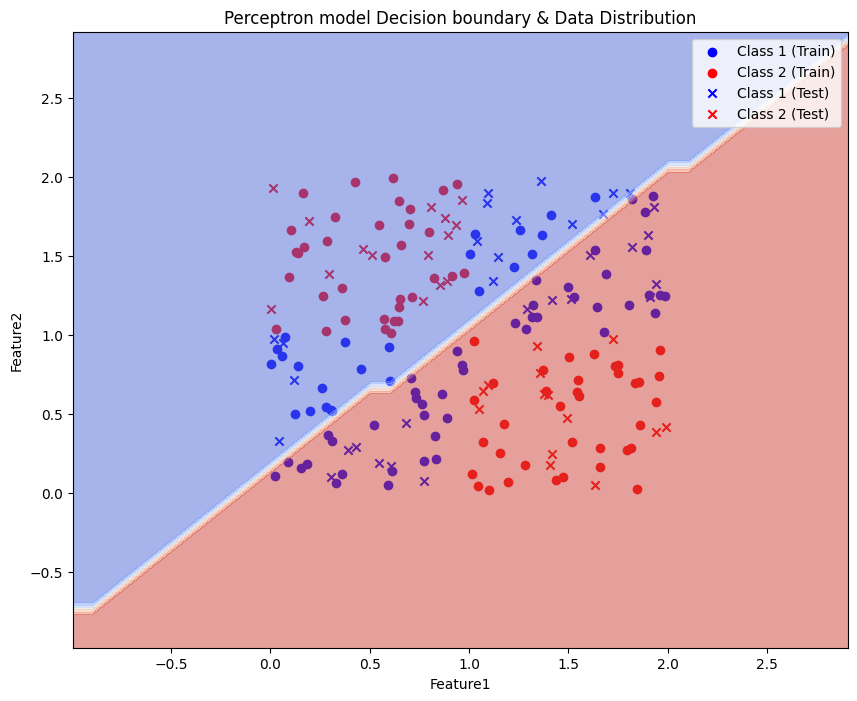

In [20]:
# perceptron model의 decision boundary와 data distribution 시각화

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

X_train_xor_cpu = X_train_xor.cpu()
y_train_xor_cpu = y_train_xor.cpu()
X_test_xor_cpu = X_test_xor.cpu()
y_test_xor_cpu = y_test_xor.cpu()

# train data는 O / test data는 X로 구분 / class는 파랑색과 빨강색으로 구분
plt.scatter(X_train_xor_cpu[y_train_xor_cpu == 0 ][:, 0], X_train_xor_cpu[y_train_xor_cpu == 0][:,1], c='blue', marker='o', label='Class 1 (Train)')
plt.scatter(X_train_xor_cpu[y_train_xor_cpu == 1][:, 0], X_train_xor_cpu[y_train_xor_cpu == 1][:,1], c='red', marker='o', label='Class 2 (Train)')
plt.scatter(X_test_xor_cpu[y_test_xor_cpu == 0][:,0], X_test_xor_cpu[y_test_xor_cpu == 0][:,1], c='blue', marker='x', label='Class 1 (Test)')
plt.scatter(X_test_xor_cpu[y_test_xor_cpu == 1][:,0], X_test_xor_cpu[y_test_xor_cpu == 1][:,1], c='red', marker='x', label='Class 2 (Test)')
plt.title('Perceptron model Decision boundary & Data Distribution')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.legend()

# 결정 경계 시각화
weights_cpu = perceptron_xor.weights.cpu().detach().numpy()
bias_cpu = perceptron_xor.bias.cpu().item()

x_min, x_max = X_train_xor_cpu[:,0].min()-1, X_train_xor_cpu[:,0].max()+1
y_min, y_max = X_train_xor_cpu[:,1].min()-1, X_train_xor_cpu[:,1].max()+1

xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.1), torch.arange(y_min, y_max, 0.1))
Z = perceptron.predict(torch.vstack((xx.flatten(), yy.flatten())).T).reshape(xx.shape)

plt.contourf(xx, yy, Z.detach().numpy(), alpha=0.5, cmap='coolwarm')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

<ipython-input-21-f47a037dde8a>:21: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_xor_cpu[y_test_xor_cpu == 0][:,0], X_test_xor_cpu[y_test_xor_cpu == 0][:,1], c='blue', marker='x', label='Class 1 (Test)', edgecolors='k')
<ipython-input-21-f47a037dde8a>:22: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_xor_cpu[y_test_xor_cpu == 1][:,0], X_test_xor_cpu[y_test_xor_cpu == 1][:,1], c='red', marker='x', label='Class 2 (Test)', edgecolors='k')


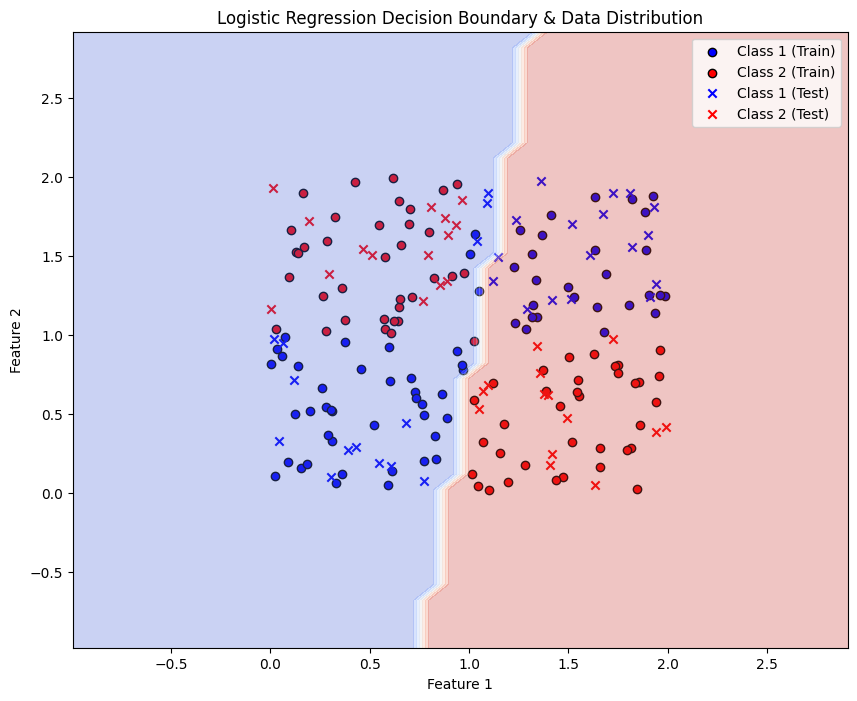

In [21]:
# Logistic regression model의 decision boundary와 data distribution 시각화

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

logistic_regression_cpu = logistic_regression.cpu()
X_train_xor_cpu = X_train_xor.cpu()
y_train_xor_cpu = y_train_xor.cpu()
X_test_xor_cpu = X_test_xor.cpu()
y_test_xor_cpu = y_test_xor.cpu()

# logistic_regression 학습된 가중치와 편향 가져오기
weights = logistic_regression.linear.weight.detach().cpu().numpy()
bias = logistic_regression.linear.bias.detach().cpu().numpy()

# Train 데이터 산포도
plt.scatter(X_train_xor_cpu[y_train_xor_cpu == 0][:, 0], X_train_xor_cpu[y_train_xor_cpu == 0][:,1], c='blue', marker='o', label='Class 1 (Train)', edgecolors='k')
plt.scatter(X_train_xor_cpu[y_train_xor_cpu == 1][:, 0], X_train_xor_cpu[y_train_xor_cpu == 1][:,1], c='red', marker='o', label='Class 2 (Train)', edgecolors='k')

# Test 데이터 산포도
plt.scatter(X_test_xor_cpu[y_test_xor_cpu == 0][:,0], X_test_xor_cpu[y_test_xor_cpu == 0][:,1], c='blue', marker='x', label='Class 1 (Test)', edgecolors='k')
plt.scatter(X_test_xor_cpu[y_test_xor_cpu == 1][:,0], X_test_xor_cpu[y_test_xor_cpu == 1][:,1], c='red', marker='x', label='Class 2 (Test)', edgecolors='k')

# 결정 경계 그리기
x_min, x_max = X_train_xor_cpu[:,0].min() - 1, X_train_xor_cpu[:,0].max() + 1
y_min, y_max = X_train_xor_cpu[:,1].min() - 1, X_train_xor_cpu[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = logistic_regression(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()).detach().cpu().numpy().argmax(axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Logistic Regression Decision Boundary & Data Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend()
plt.show()

* MLP 모델의 decision boundary와 data를 2d에서 확인 할 수 있도록 생성 (10)

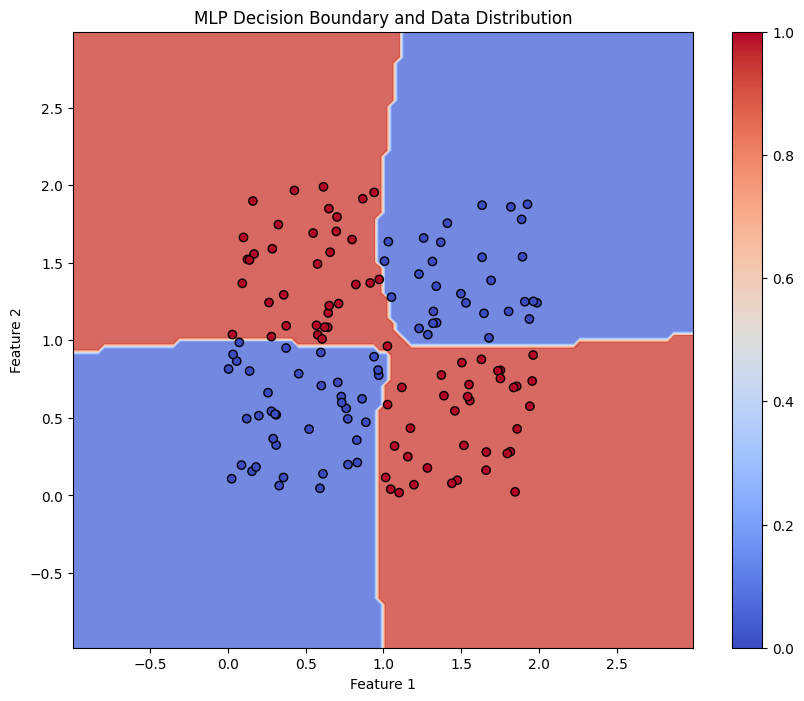

In [22]:
# MLP model의 decision boundary와 data distribution 시각화

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,8))

model_cpu=model.cpu()

# 함수 정의: 결정 경계 시각화
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
    Z = model_cpu(grid_tensor).detach().numpy()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('MLP Decision Boundary and Data Distribution')
    plt.colorbar()
    plt.show()

# 모델과 데이터 준비
model_cpu.eval()  # 모델을 평가 모드로 설정
X_train_np = X_train_xor.cpu().numpy()
y_train_np = y_train_xor.cpu().numpy()

# 결정 경계 시각화
plot_decision_boundary(model, X_train_np, y_train_np)


* Logistic regression model이 non-linear function인 sigmoid를 사용하는데 왜 linear classifier라고 하는지 decision boundary 관점 에서 설명 (10)


classfication 모델에서는 hyperplane의 formula가 선형형태인지 아닌지에 따라 linear method인지 아닌지로 구분되기 때문이다.

Logistic regression의 hyperplane formula 유도식을 살펴보면 이진분류 문제에서 분류 결정은 오즈비가 1보다 크냐에 따라 0, 1인지 결정된다. 여기에 log를 씌워 계산하다보면 w0+∑iwiXi > 0 이라는 식이 도출되게 되고, 결론적으로 해당 formula가 선형식이기 때문에 Logistic regression이 linear classfier라고 할 수 있다.



따라서 로지스틱 회귀 모델은 비선형 함수인 시그모이드를 사용하지만, 결정 경계의 관점에서는 linear classfier로 간주된다. 이는 결정 경계가 선형적인 형태를 갖는다는 의미에서 linear classfier로 분류되는 것이다.

로지스틱 회귀에서는 선형 결합에 대한 로그 우도(log likelihood)를 최대화하는 방향으로 모델 파라미터를 조정한다. 이를 통해 결정 경계가 형성되며, 이 결정 경계는 선형적인 형태를 가진다. 결정 경계는 입력 특성의 가중치 합에 편향을 더한 것으로 정의된다.

결국, 로지스틱 회귀는 선형 결합을 기반으로 hyperplane을 형성하여 클래스를 분류하며, 이러한 이유로 linear classfier로 간주된다.